<a href="https://colab.research.google.com/github/Aasish1234/River_bank/blob/main/river2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  scikit-fuzzy tqdm
!pip install scikit-fuzzy



In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# === Step 1: Load Dataset ===
file_path = '/content/PREPROCESSED_DATASET (2).csv'
df = pd.read_csv(file_path)

# === Step 2: Map Labels to Fuzzy Scale ===
eri_mapping = {'Low': 0, 'Medium': 50, 'High': 100}
rhs_mapping = {'Poor': 0, 'Moderate': 50, 'Good': 100}

df['ERI_numeric'] = df['ERI_Label'].map(eri_mapping)
df['RHS_numeric'] = df['RHS_Label'].map(rhs_mapping)

# === Step 3: Define Fuzzy Variables ===
eri = ctrl.Antecedent(np.arange(0, 101, 1), 'eri')
rhs = ctrl.Antecedent(np.arange(0, 101, 1), 'rhs')
condition = ctrl.Consequent(np.arange(0, 101, 1), 'condition')

# Membership functions
eri['low'] = fuzz.trimf(eri.universe, [0, 0, 50])
eri['medium'] = fuzz.trimf(eri.universe, [25, 50, 75])
eri['high'] = fuzz.trimf(eri.universe, [50, 100, 100])

rhs['poor'] = fuzz.trimf(rhs.universe, [0, 0, 50])
rhs['moderate'] = fuzz.trimf(rhs.universe, [25, 50, 75])
rhs['good'] = fuzz.trimf(rhs.universe, [50, 100, 100])

condition['worst'] = fuzz.trimf(condition.universe, [0, 0, 40])
condition['ok'] = fuzz.trimf(condition.universe, [30, 50, 70])
condition['good'] = fuzz.trimf(condition.universe, [60, 100, 100])

# === Step 4: Define Fuzzy Rules ===
rules = [
    ctrl.Rule(eri['high'] & rhs['poor'], condition['worst']),
    ctrl.Rule(eri['high'] & rhs['moderate'], condition['ok']),
    ctrl.Rule(eri['high'] & rhs['good'], condition['ok']),
    ctrl.Rule(eri['medium'] & rhs['poor'], condition['ok']),
    ctrl.Rule(eri['medium'] & rhs['moderate'], condition['ok']),
    ctrl.Rule(eri['medium'] & rhs['good'], condition['good']),
    ctrl.Rule(eri['low'] & rhs['moderate'], condition['good']),
    ctrl.Rule(eri['low'] & rhs['good'], condition['good']),
    ctrl.Rule(eri['low'] & rhs['poor'], condition['ok'])  # catch-all
]

# === Step 5: Build Control System ===
condition_ctrl = ctrl.ControlSystem(rules)
condition_sim = ctrl.ControlSystemSimulation(condition_ctrl)

# === Step 6: Apply Fuzzy Model ===
def compute_condition_score(eri_val, rhs_val):
    condition_sim.input['eri'] = eri_val
    condition_sim.input['rhs'] = rhs_val
    try:
        condition_sim.compute()
        return condition_sim.output['condition']
    except:
        return 50  # fallback

df['River_Condition_Score'] = df.apply(lambda row: compute_condition_score(row['ERI_numeric'], row['RHS_numeric']), axis=1)

# === Step 7: Score to Category ===
def label_from_score(score):
    if score <= 40:
        return 'Worst'
    elif score <= 70:
        return 'Ok'
    else:
        return 'Good'

df['River_Condition'] = df['River_Condition_Score'].apply(label_from_score)

# === Step 8: Save & Display Results ===
df.to_csv('final_fuzzy_river_condition_output.csv', index=False)
print(df['River_Condition'].value_counts())


Ok       604
Good     217
Worst    172
Name: River_Condition, dtype: int64


In [ ]:
df=pd.read_csv("/content/final_fuzzy_river_condition_output.csv")
df

,River_ID,Location,Latitude,Longitude,Erosion Rate (m/yr),Total Erosion Time(yr),StartYear,EndYear,Channel Width (m),DrainageArea(km^2)_rabpro,...,Sediment_Efficiency,log_slope,log_discharge_area,log_sed_eff,ERI_Label,RHS_Label,ERI_numeric,RHS_numeric,River_Condition_Score,River_Condition
0,Strickland River,Papua New Guinea,-7.213544,141.761081,5.14,28.0,1972.0,2000.0,350.0,26047.2,...,24193.548387,-7.464887,0.790658,4.383700,High,Good,100,100,50.000000,Ok
1,Strickland River,Papua New Guinea,-7.213544,141.761081,5.72,10.0,1990.0,2000.0,350.0,26047.2,...,24193.548387,-7.464887,0.790658,4.383700,High,Good,100,100,50.000000,Ok
2,Niger (Ndoni-Asambari section),Nigeria,5.433592,6.525075,4.75,6.0,1988.0,1993.0,1307.0,2017256.4,...,10994.475138,-6.103017,0.858005,4.041175,Medium,Poor,50,0,50.000000,Ok
3,Queets River,Washington,47.550719,-124.258897,10.00,5.0,1931.0,1985.0,40.0,718.6,...,8735.909823,-4.290306,0.916297,3.941308,High,Poor,100,0,13.333333,Worst
4,Niger_delta,Nigeria,5.334603,6.503359,6.30,30.0,1985.0,2015.0,1152.0,2017412.6,...,6981.402003,-5.819699,0.967682,3.843943,High,Poor,100,0,13.333333,Worst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,Hanjiang_2,China,32.234900,111.697500,8.00,10.0,1968.0,1978.0,1000.0,103109.6,...,6369.426752,-7.387794,-1.947115,3.804100,High,Poor,100,0,13.333333,Worst
989,Hanjiang_2,China,32.234900,111.697500,22.00,6.0,1978.0,1984.0,1000.0,103109.6,...,6369.426752,-7.408598,-1.947115,3.804100,High,Poor,100,0,13.333333,Worst
990,Hanjiang_2,China,32.234900,111.697500,35.00,3.0,1984.0,1987.0,1000.0,103109.6,...,6369.426752,-7.430449,-1.947115,3.804100,High,Poor,100,0,13.333333,Worst
991,Lwr Jingjiang Yangtze,China,29.525347,113.050328,11.62,4.0,2009.0,2013.0,860.0,1011352.8,...,703.828829,-7.387956,-0.990482,2.847467,High,Poor,100,0,13.333333,Worst


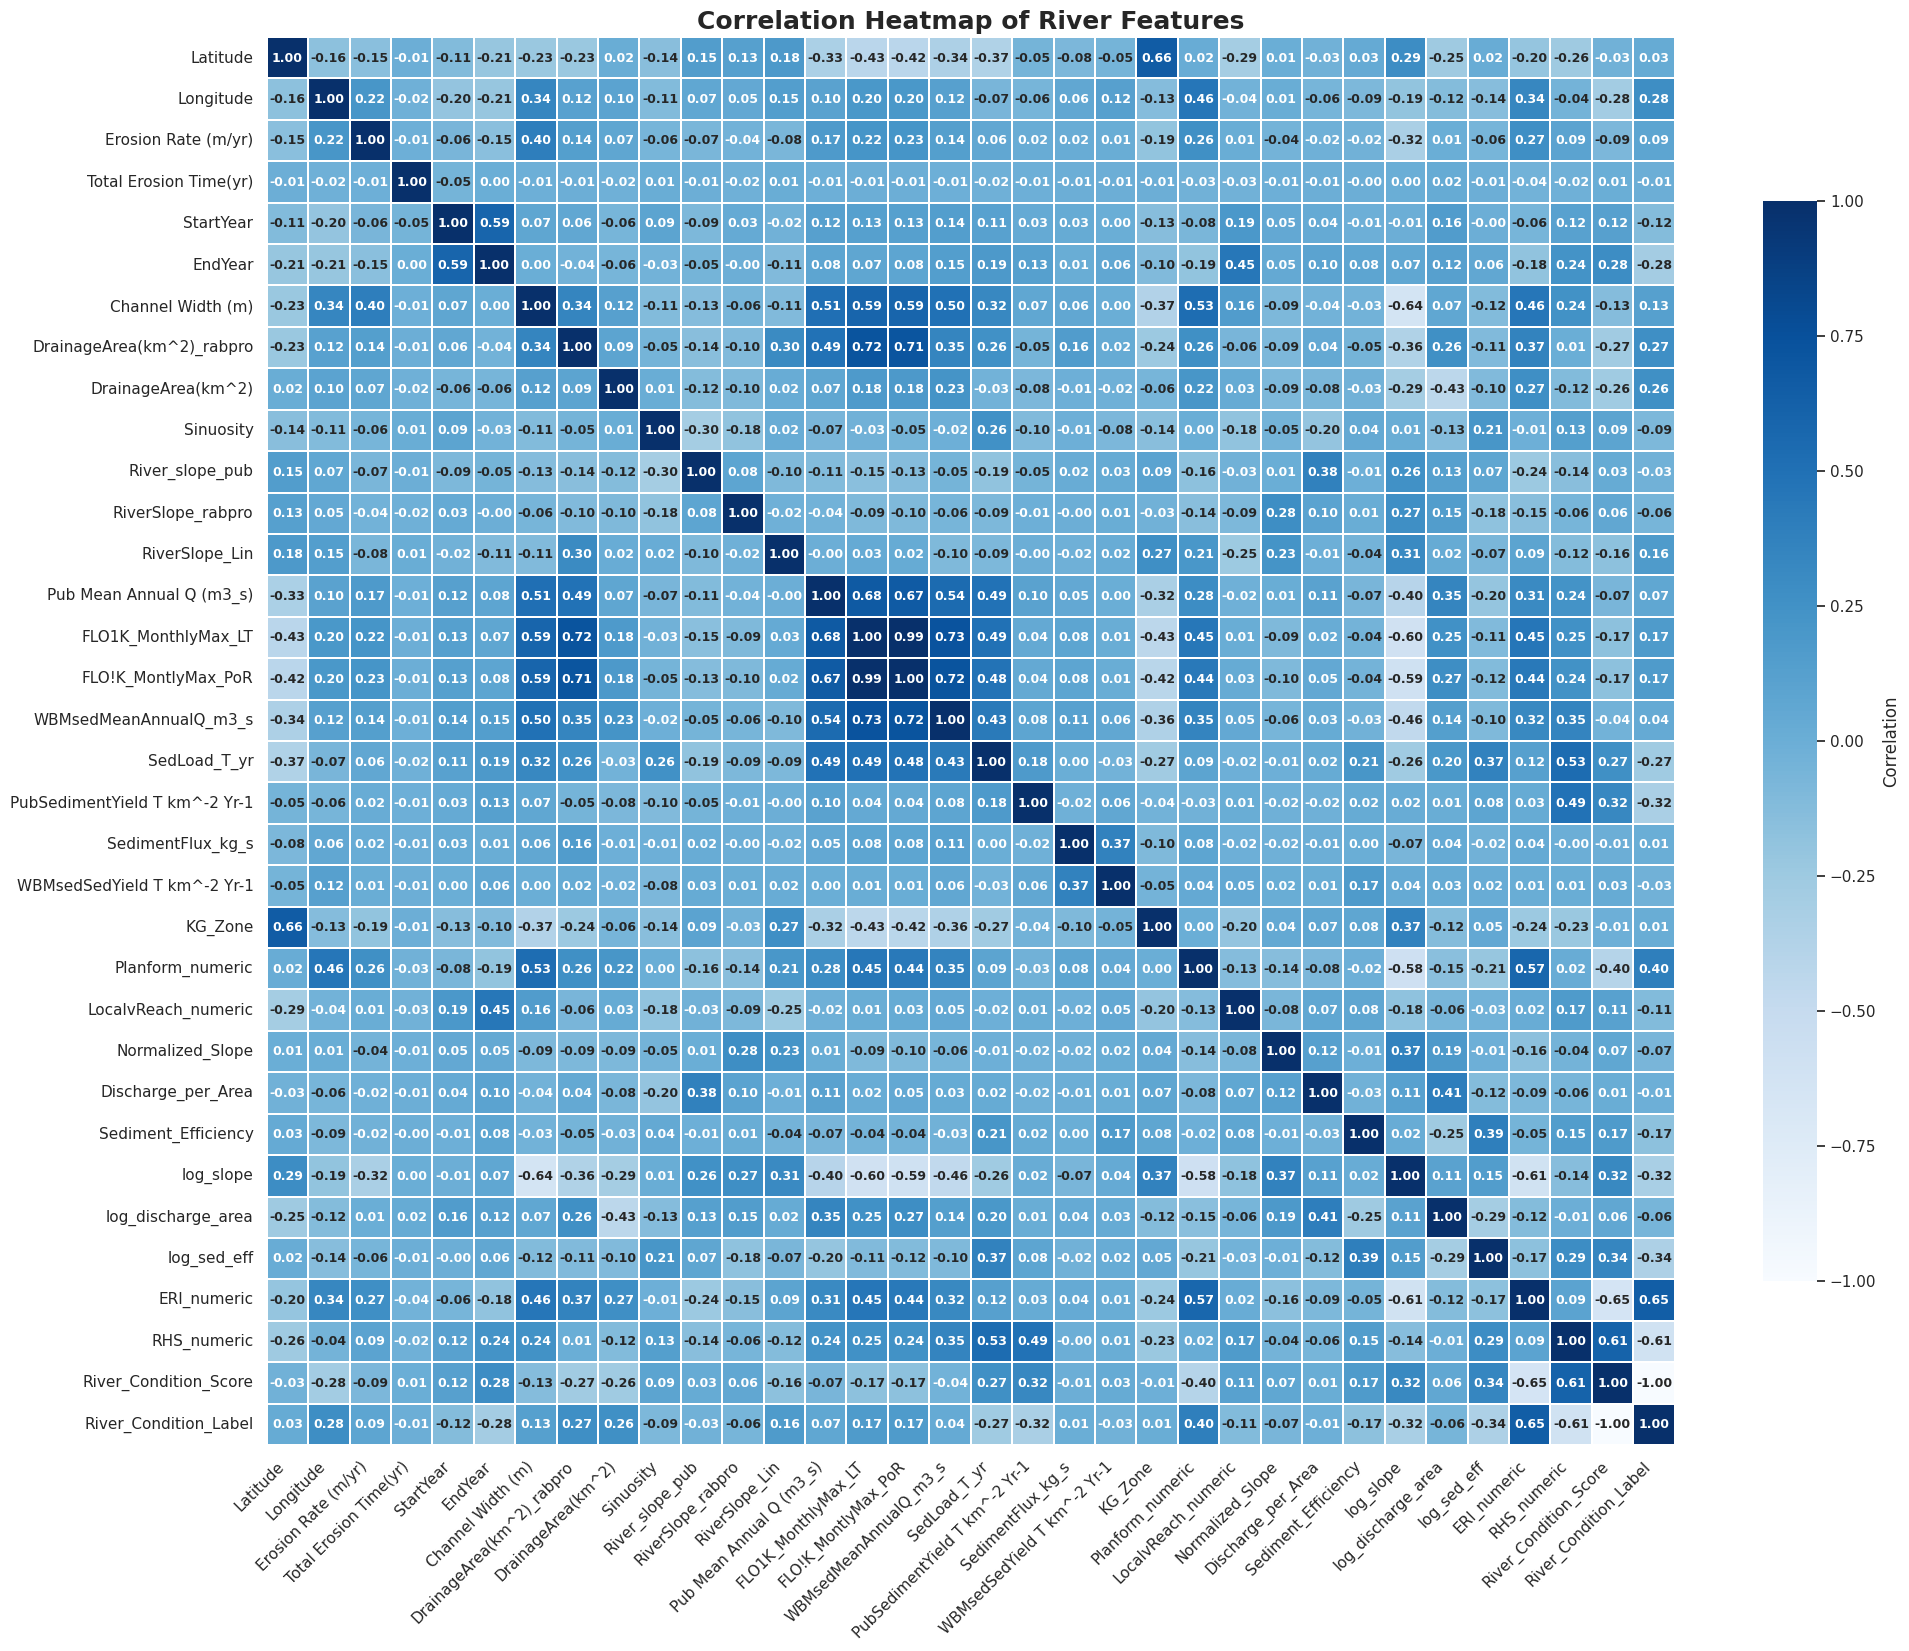

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns and compute correlation matrix
numeric_cols = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

# Set Seaborn style
sns.set(style='white')

# Create a larger figure for spacing
plt.figure(figsize=(22, 18))  # Wider figure for better spacing

# Draw heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    square=True,
    linewidths=1.2,
    linecolor='white',
    cbar_kws={'shrink': 0.75, 'label': 'Correlation'},
    annot_kws={'size': 9, 'weight': 'bold'}  # Smaller annotation font
)

# Improve axis label readability
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Add space around the plot
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

plt.title('Correlation Heatmap of River Features', fontsize=18, weight='bold')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['River_Condition_Label'] = label_encoder.fit_transform(df['River_Condition'])

# Mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Good': 0, 'Ok': 1, 'Worst': 2}


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np

# Columns to drop
drop_columns = ['River_ID', 'Location', 'River_Condition_Label','ERI_numeric','RHS_numeric','River_Condition']

# Separate features
X = df.drop(columns=drop_columns)

# Encode categorical features: ERI_Label and RHS_Label
label_encoder_eri = LabelEncoder()
X['ERI_Label_enc'] = label_encoder_eri.fit_transform(X['ERI_Label'])

label_encoder_rhs = LabelEncoder()
X['RHS_Label_enc'] = label_encoder_rhs.fit_transform(X['RHS_Label'])

# Drop original categorical columns now encoded
X = X.drop(columns=['ERI_Label', 'RHS_Label'])

# Fill missing values if any
X.fillna(X.mean(), inplace=True)

# Normalize all features (including encoded labels)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Target variable
y = df['River_Condition_Label'].values


In [ ]:
# Reshape for LSTM - single timestep
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


In [ ]:
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_categorical, test_size=0.3, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras.utils import to_categorical # No longer needed here

# --- CBAM Attention Block ---
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention Module
    avg_pool = layers.GlobalAveragePooling1D()(input_feature)
    max_pool = layers.GlobalMaxPooling1D()(input_feature)

    shared_mlp = tf.keras.Sequential([
        layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True),
        layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    ])

    avg_pool = shared_mlp(avg_pool)
    max_pool = shared_mlp(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, channel))(channel_attention)  # for broadcasting

    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention Module
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = layers.Conv1D(filters=1, kernel_size=7, padding='same',
                                      activation='sigmoid',
                                      kernel_initializer='he_normal',
                                      use_bias=False)(concat)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


# --- Prepare your data ---
# Assuming X_train, X_test are shaped (samples, timesteps, features)
# and y_train, y_test are integer labels for 3 classes (0,1,2)

# One-hot encode target labels
# y_train_cat = to_categorical(y_train, num_classes=3) # Remove this line
# y_test_cat = to_categorical(y_test, num_classes=3)   # Remove this line

# --- Build Model ---
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = layers.Input(shape=input_shape)

x = layers.LSTM(64, return_sequences=True)(inputs)
x = cbam_block(x)   # CBAM attention applied here
x = layers.LSTM(32)(x)  # Second LSTM layer without sequences
x = layers.Dense(32, activation='mish')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# --- Train ---
# Use y_train and y_test directly which are already one-hot encoded
history = model.fit(X_train, y_train, # Changed y_train_cat to y_train
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test)) # Changed y_test_cat to y_test

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1, 33)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 1, 64)     │     25,088 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ lstm_24[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ lstm_24[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 64)        │      1,096 │ global_average_p… │
│ (Sequential)        │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64)        │          0 │ sequential_12[0]… │
│                     │                   │            │ sequential_12[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64)        │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 64)     │          0 │ activation_12[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_24         │ (None, 1, 64)     │          0 │ lstm_24[0][0],    │
│ (Multiply)          │                   │            │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None, 1, 1)      │          0 │ multiply_24[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_25 (Lambda)  │ (None, 1, 1)      │          0 │ multiply_24[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 1, 2)      │          0 │ lambda_24[0][0],  │
│ (Concatenate)       │                   │            │ lambda_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1, 1)      │         14 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_25         │ (None, 1, 64)     │          0 │ multiply_24[0][0… │
│ (Multiply)          │                   │            │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 32)        │     12,416 │ multiply_25[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 32)        │      1,056 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 3)         │         99 │ dense_50[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,769 (155.35 KB)

 Trainable params: 39,769 (155.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6201 - loss: 1.0825 - val_accuracy: 0.6309 - val_loss: 1.0195
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5901 - loss: 1.0048 - val_accuracy: 0.6309 - val_loss: 0.9021
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5839 - loss: 0.9490 - val_accuracy: 0.6309 - val_loss: 0.8820
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5931 - loss: 0.9203 - val_accuracy: 0.6309 - val_loss: 0.8556
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5845 - loss: 0.9027 - val_accuracy: 0.6309 - val_loss: 0.7943
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5695 - loss: 0.8323 - val_accuracy: 0.6309 - val_loss: 0.6460
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6572 - loss: 0.6110 - val_accuracy: 0.9262 - val_loss: 0.3765
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8969 - loss: 0.3388 - val_accuracy: 0.9530 - va

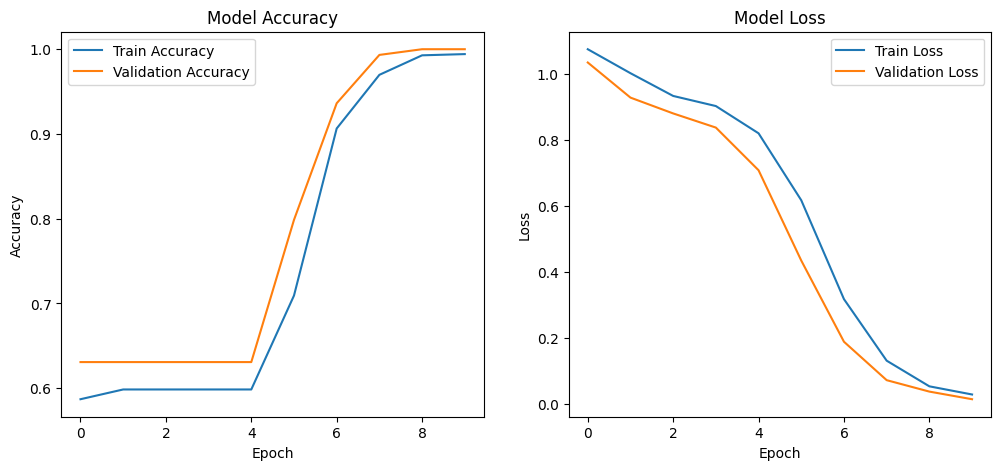

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


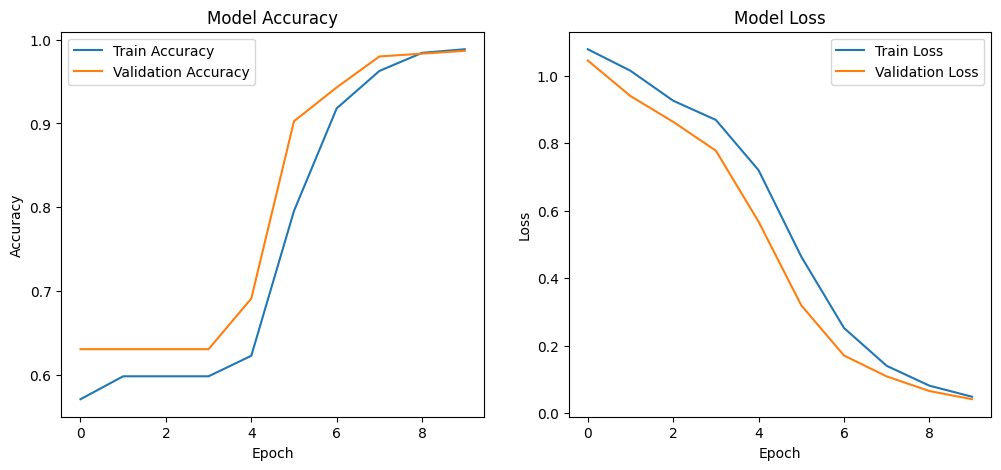

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


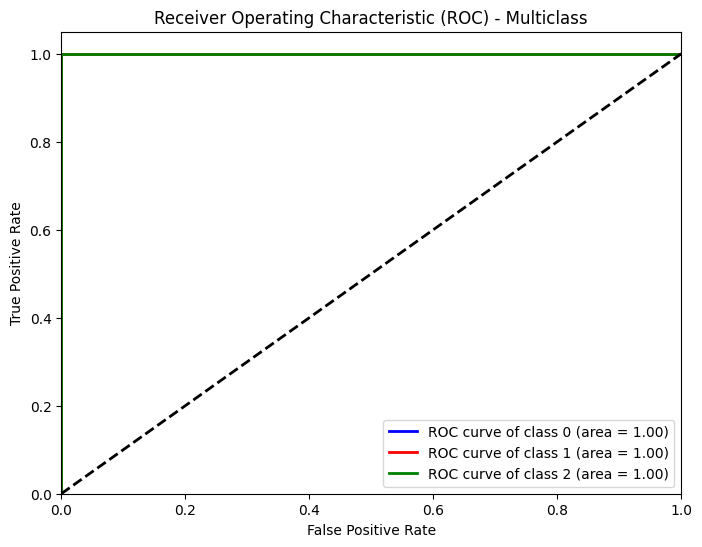

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import numpy as np

# --- 1. Plot learning curves ---

def plot_learning_curves(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)


# --- 2. Compute and plot ROC-AUC for each class ---

# If your y_test is integer labels, convert to one-hot:
if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    y_test_cat = to_categorical(y_test, num_classes=3)
else:
    y_test_cat = y_test

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

n_classes = y_test_cat.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9862 - loss: 0.0411 
Test Accuracy: 0.99


In [ ]:
import numpy as np

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
decoded_preds = label_encoder.inverse_transform(predicted_classes)

print(decoded_preds[:10])  # Print first 10 predictions


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
['Ok' 'Ok' 'Ok' 'Good' 'Ok' 'Worst' 'Good' 'Ok' 'Ok' 'Worst']


In [ ]:
# Decode actual values
true_classes = np.argmax(y_test, axis=1)
decoded_true = label_encoder.inverse_transform(true_classes)

# Decode predicted values (already done)
predicted_classes = np.argmax(predictions, axis=1)
decoded_preds = label_encoder.inverse_transform(predicted_classes)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({
    'Actual': decoded_true,
    'Predicted': decoded_preds
})

# Show first 10 comparisons
print(comparison_df.head(10))


  Actual Predicted
0     Ok        Ok
1     Ok        Ok
2     Ok        Ok
3   Good      Good
4     Ok        Ok
5  Worst     Worst
6   Good      Good
7     Ok        Ok
8     Ok        Ok
9  Worst     Worst


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(decoded_true, decoded_preds))

              precision    recall  f1-score   support

        Good       0.94      1.00      0.97        62
          Ok       1.00      0.98      0.99       188
       Worst       1.00      1.00      1.00        48

    accuracy                           0.99       298
   macro avg       0.98      0.99      0.99       298
weighted avg       0.99      0.99      0.99       298



In [ ]:
!pip install alibi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 89.9 MB/s eta 0:00:00

In [ ]:
import alibi
print(alibi.__version__)  # Should be >= 0.7.x


0.9.6


In [ ]:
import tensorflow as tf
print(tf.__version__)  # Should be >= 2.11


2.18.0


In [ ]:
!pip install dice-ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.3.1 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1

In [ ]:
import dice_ml
from dice_ml.utils import helpers

# Prepare data for DiCE
# Create a DataFrame with scaled features (not reshaped for LSTM)
import pandas as pd

X_flat = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])
y_flat = df['River_Condition_Label']  # 0,1,2 labels (not one-hot)

# Define data object
data_dice = dice_ml.Data(dataframe=pd.concat([X_flat, y_flat], axis=1),
                         continuous_features=X_flat.columns.tolist(),
                         outcome_name='River_Condition_Label')

# Use model from tf.keras
model_dice = dice_ml.Model(model=model, backend='TF2')


In [ ]:
# file ipython-input-23-128cca8ccb92

import dice_ml
from dice_ml.utils import helpers
import pandas as pd
import tensorflow as tf # Import tensorflow
from tensorflow.keras import layers, models # Import necessary Keras components


# Prepare data for DiCE
# Create a DataFrame with scaled features (not reshaped for LSTM)
X_flat = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])
y_flat = df['River_Condition_Label']  # 0,1,2 labels (not one-hot)

# Define data object
data_dice = dice_ml.Data(dataframe=pd.concat([X_flat, y_flat], axis=1),
                         continuous_features=X_flat.columns.tolist(),
                         outcome_name='River_Condition_Label')

# --- Custom Prediction Function Wrapper ---
# DiCE passes 2D data (samples, features) to the predict function.
# Our LSTM model expects 3D data (samples, timesteps, features).
# This wrapper reshapes the input before passing it to the model.
# Add the 'training' argument to the wrapper's signature
def predict_wrapper(x, training=False): # Added training=False
    # Assuming your LSTM model expects 1 timestep, reshape from (samples, features) to (samples, 1, features)
    x_reshaped = tf.reshape(x, [-1, 1, x.shape[-1]])
    return model(x_reshaped, training=training) # Pass the received training argument

# Use the custom prediction function when defining the model for DiCE
# Provide the predict_wrapper function instead of the model object directly
model_dice = dice_ml.Model(model=predict_wrapper, backend='TF2', model_type='classifier') # Specify model_type explicitly

# file ipython-input-21-4de7619edafd

# Initialize DiCE explainer
exp = dice_ml.Dice(data_dice, model_dice)

# Choose a query instance from your test set
# Get the first instance as a DataFrame row
query_instance_df = X_flat.iloc[[0]] # Use double brackets to keep it a DataFrame

# Reshape the query instance to match the LSTM input shape (samples, timesteps, features)
# Note: We still reshape here, but the wrapper handles the transformation for the model's predict call.
# DiCE expects a DataFrame as input to generate_counterfactuals.
# We pass the original 2D DataFrame from X_flat here.
# The predict_wrapper handles the reshaping internally before calling the Keras model.
query_instance_for_dice = X_flat.iloc[[4]] # Use the 2D DataFrame directly

# Generate diverse counterfactuals
# Pass the 2D DataFrame query instance to generate_counterfactuals
# CHANGE: Specify the desired class(es) as integers (e.g., 0 for 'Good', 1 for 'Ok', 2 for 'Worst')
# Replace "opposite" with the integer label you want to achieve
dice_exp = exp.generate_counterfactuals(query_instance_for_dice, total_CFs=3, desired_class=0) # Example: Target class 0 ('Good')

# Visualize
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

Query instance (original outcome : 2)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,River_Condition_Label
0,0.439054,0.494623,0.002447,0.002099,0.973188,0.98,0.057552,0.681617,0.000319,0.453988,...,0.000665,0.001214,0.000003,0.467694,0.712764,0.579309,0.0,0.0,1.0,2



Diverse Counterfactual set (new outcome: 0)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,River_Condition_Label
0,0.439054,0.626821,0.002447,0.002099,0.973188,0.98,0.057552,0.681617,0.000319,0.453988,...,0.000665,0.001214,0.000003,0.467694,0.712764,0.664390,1.0,0.0,0.0,0
1,0.439054,0.494623,0.002447,0.002099,0.973188,0.98,0.057552,0.681617,0.000319,0.453988,...,0.000665,0.001214,0.000003,0.179301,0.792432,0.579309,1.0,0.0,0.0,0
2,0.439054,0.626821,0.002447,0.002099,0.973188,0.98,0.057552,0.681617,0.000319,0.453988,...,0.000665,0.001214,0.000003,0.467694,0.712764,0.664390,1.0,0.0,0.0,0


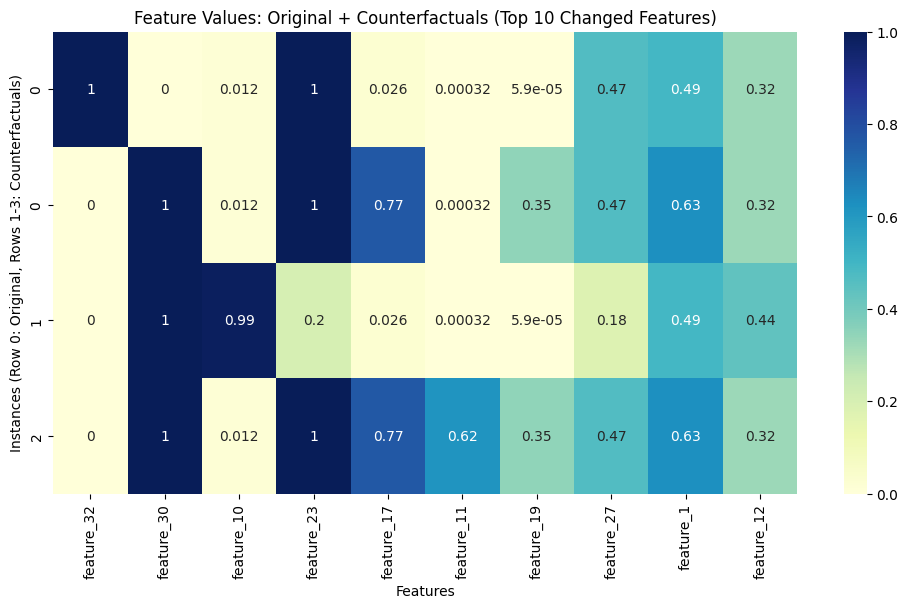

<Figure size 1200x600 with 0 Axes>

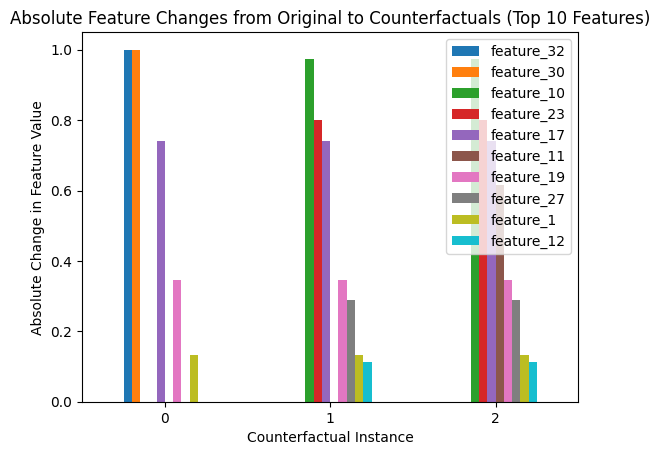

Feature comparison (Original + Counterfactuals):
   feature_32  feature_30  feature_10  feature_23  feature_17  feature_11  \
0         1.0         0.0    0.012241         1.0    0.026237    0.000321   
0         0.0         1.0    0.012241         1.0    0.767267    0.000321   
1         0.0         1.0    0.985394         0.2    0.026237    0.000321   
2         0.0         1.0    0.012241         1.0    0.767267    0.615533   

   feature_19  feature_27  feature_1  feature_12  
0    0.000059    0.467694   0.494623    0.324887  
0    0.346379    0.467694   0.626821    0.324887  
1    0.000059    0.179301   0.494623    0.436593  
2    0.346379    0.467694   0.626821    0.324887  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assume these are your original and CF dataframes from DiCE output
original = query_instance_for_dice.iloc[0]  # original single row Series
counterfactuals = dice_exp.cf_examples_list[0].final_cfs_df.drop(columns=['River_Condition_Label'])

# Add the original as the first row for comparison
cf_with_original = pd.concat([original.to_frame().T.reset_index(drop=True), counterfactuals.reset_index(drop=True)])

# Calculate feature differences (absolute)
diffs = cf_with_original.diff().fillna(0).abs()

# Visualize feature values across original + counterfactuals for top changed features
# Find top features with highest difference between original and any CF
top_features = diffs.max().sort_values(ascending=False).head(10).index.tolist()

plt.figure(figsize=(12, 6))
sns.heatmap(cf_with_original[top_features], annot=True, cmap="YlGnBu", cbar=True)
plt.title("Feature Values: Original + Counterfactuals (Top 10 Changed Features)")
plt.xlabel("Features")
plt.ylabel("Instances (Row 0: Original, Rows 1-3: Counterfactuals)")
plt.show()

# Bar plot of absolute differences per CF for these top features
plt.figure(figsize=(12, 6))
diffs[top_features].iloc[1:].plot(kind='bar', stacked=False)
plt.title("Absolute Feature Changes from Original to Counterfactuals (Top 10 Features)")
plt.xlabel("Counterfactual Instance")
plt.ylabel("Absolute Change in Feature Value")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

# Summary table with original vs CF feature values for top features
summary_df = cf_with_original[top_features]
print("Feature comparison (Original + Counterfactuals):")
print(summary_df)
